<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/4_0_modeling_classification_DSBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

This lecture is taken from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md). 

In the previous lectures we have worked on data understanding and data preparation, and trained some first machine learning algorithms:

- In **lecture 1** we focused on data understanding and explored various possible outcome parameters.
- In **lecture 2** we constructed a combined outcome parameter using cut-off points for pain and physical functioning.
- In **lecture 3** we performed regression, LASSO and KNN on the outcome `t1_eq_vas`.

# Learning objectives

The main objective in this lecture is to learn how to build and interpret tree-based machine learning algorithms. We will look at the following algorithms:
- Decision tree
- Random Forest
- Gradient Boosting

Where the previous notebook targeted a numeric outcome, the models in this notebook aim to predict a categorical outcome. In notebook 2, we explored two possible definitions for the categorical outcome:
- `y_mcid`: a binary outcome, defined as good (True/1) if `t1_oks_score` is above the threshold <b>or</b> `delta_oks_score` is larger than MCID;
- `y_t1_pain_good` and `y_t1_functioning_good`: an outcome with four classes, combining the two binary outcomes on pain and functioning.

In this notebook, we predict a binary outcome which is defined as a good outcome when both pain <b>and</b> functioning is good at `t1`

Along with learning about tree-based models, you will learn about performance metrics in case of a binary outcome, and about grid search to help tuning hyperparameters when it is not feasible to try out all possible values.

Some examples are given to visualize scoring functions of models to aid in model selection.


### References used: 

#### Python: Hands-on Machine Learning (2nd edition)

- [Classification (chapter 3)](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
- [Support-vector machines (chapter 5)](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb)
- [Decision trees (chapter 6)](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb)
- [Ensemble learning and random forests (chapter 7)](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

#### Python: scikit-learn and matplotlib
- [Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
- [Visualizations](https://scikit-learn.org/stable/visualizations.html#visualizations)
- [Real Python Matplotlib guide](https://realpython.com/python-matplotlib-guide/)
- [Matplotlib anatomy](https://matplotlib.org/3.2.2/gallery/showcase/anatomy.html)
- [Yellowbrick](https://www.slideshare.net/RebeccaBilbro/learning-machine-learning-with-yellowbrick)

# Importing data and settings

Let's start by re-running the relevant code from previous lectures, after which we can continue extending our pipelines to experiment with different classifiers.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# read data
df = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# Data Splitting and Data Preparation

The code below performs the data preparation, including imputing missing values, adding additional features (such as the total number of comorbidities), defining the outcome Y (which is a positive when a patient scores good on both pain and functioning and negative otherwise)

In [2]:
# handy function to select oks columns
def oks_questions(t='t0'):
  return [
    col for col in df.columns if col.startswith(f"oks_{t}") and not col.endswith("_score")
]

# replace sentinel values in oks columns
# note we are doing imputation on original dataframe (rather than in pipeline later on)
# so we can perform it prior to StratifiedShuffleSplit
oks_no9 = oks_questions('t0') + oks_questions('t1')
impute_oks = SimpleImputer(missing_values=9, strategy="most_frequent")
df.loc[:, oks_no9] = impute_oks.fit_transform(df[oks_no9])

# group columns t0
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]
oks_score = ["oks_t0_score"]

# add number of comorbidities as extra feature
impute_comorb = SimpleImputer(missing_values=9, strategy="constant", fill_value=0)
df.loc[:, comorb] = impute_comorb.fit_transform(df[comorb])
df["n_comorb"] = df.loc[:, comorb].sum()


# define outcome Y
CUT_OFF_PAIN = 4
CUT_OFF_FUNCTIONING = 26

for t in ("t0", "t1"):
    df[f"oks_{t}_pain_total"] = df[f"oks_{t}_pain"] + df[f"oks_{t}_night_pain"]
    df[f"oks_{t}_functioning_total"] = (
        df.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
    df[f"y_{t}_pain_good"] = df[f"oks_{t}_pain_total"].apply(
        lambda s: True if s >= CUT_OFF_PAIN else False
    )
    df[f"y_{t}_functioning_good"] = df[f"oks_{t}_functioning_total"].apply(
        lambda s: True if s >= CUT_OFF_FUNCTIONING else False
    )

# define binary outcome parameter
df["y_binary"] = np.logical_and(df.y_t1_pain_good, df.y_t1_functioning_good)

# Only using 1 split for stratified sampling, more folds are used later on in cross-validation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["y_binary"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    
y_train_pain_good = df_train.y_t1_pain_good
y_train_functioning_good = df_train.y_t1_functioning_good
y_train_binary = df_train.y_binary

y_test_pain_good = df_test.y_t1_pain_good
y_test_functioning_good = df_test.y_t1_functioning_good
y_test_binary = df_test.y_binary

The two tables below show us the distribution of the outcome variable, both at `t0` and at `t1`. These tables indicate that the majority of patients have bad outcomes on both pain and functioning prior to surgery and good outcomes on both outcomes after surgery.

In [3]:
y0 = pd.crosstab(df_train.y_t0_pain_good, df_train.y_t0_functioning_good, normalize=True)
y0

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [4]:
y1 = pd.crosstab(df_train.y_t1_pain_good, df_train.y_t1_functioning_good, normalize=True)
y1

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


Having used StratifiedSplit should have resulted in a similar distribution of good and bad outcomes in both the train and the test set (at `t1`):

In [5]:
print("fraction good outcomes in train set:",str(df_train['y_binary'].sum()/len(df_train['y_binary'])))
print("fraction good outcomes in test set:", str(df_test['y_binary'].sum()/len(df_test['y_binary'])))


fraction good outcomes in train set: 0.7073410968039809
fraction good outcomes in test set: 0.7073328385722152


We introduce the same pipeline as in the previous notebook, including the imputation functions for missings or sentinel values, as well as encoder functions for encoding variables as e.g. dummies.

In [6]:
# same pipeline as lecture 3
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)
gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        'passthrough',
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        'passthrough',
        oks_questions('t0'),
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

In [7]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_train = prep.fit_transform(df_train)
X_test = prep.fit_transform(df_test)
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions()
    + eq_vas
)

At the end of data preparation, it is always important to check the result, to see whether every variable is defined as you intended. Remember, with programming it is easy to lose track of what is happening, and the only way to check your work is to visualize and describe the data at regular intervals.

In [8]:
pd.DataFrame(data = X_train, columns = X_columns).head(5)

,age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_assisted,t0_previous_surgery,t0_disability,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_pain_total,oks_t0_functioning_total,t0_eq_vas
0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,25.0,70.0
1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,28.0,70.0
2,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,25.0
3,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,18.0,70.0
4,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,13.0,68.0


# Modeling

We now start developing models for predicting the outcome of surgery, where we chose to define a good outcome by having good functioning and less pain, which is achieved by 71% (see tables above)

## Decision Tree (CART)

In [16]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

cart = Pipeline(
    steps=[
        ("prep", prep),
        ("cart", DecisionTreeClassifier()),
    ]
)

cart_parameters = {
'cart__max_depth': [4, 6],
'cart__min_samples_leaf': [0.02, 0.05, 0.1, 0.2],
}

cart_search = GridSearchCV(cart, cart_parameters, cv=5)
_ = cart_search.fit(df_train, y_train_binary);

CPU times: user 13 s, sys: 166 ms, total: 13.1 s
Wall time: 13.1 s


In [17]:
confusion_matrix(y_train_binary, cart_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.059, 0.234],
       [0.04 , 0.668]])

In [18]:
cross_val_score(cart_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc").round(3)

array([0.684, 0.689, 0.681])

We can explore what the Decision Tree looks like, which is actually one of the main benefits of using a Decision Tree: it is a highly interpretable machine learning algorithm:

In [19]:
cart_search.best_estimator_['cart']

DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.02)

In [20]:
from sklearn.tree import export_graphviz
export_graphviz(cart_search.best_estimator_['cart'], 'tree.dot', feature_names = X_columns)

In [21]:
!dot -Tpng tree.dot -o tree.png

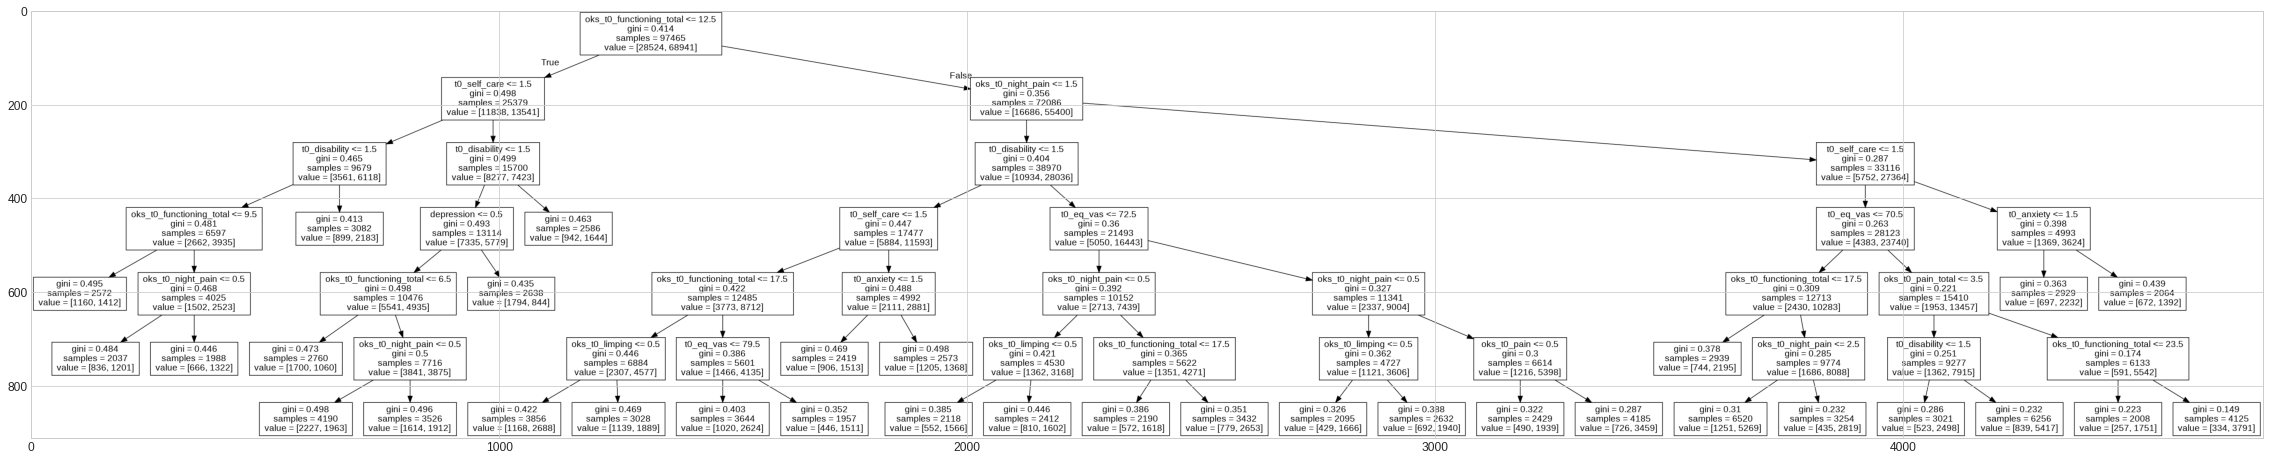

In [22]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (40, 40))
plt.imshow(img)

### ROC curve
The ROC curve helps to visualize the tradeoffs you face between sensitivity and specificity for different probability thresholds. ROC curves are typically less intuitive to depicting performance tradeoffs than precision-recall curves, introduced later.

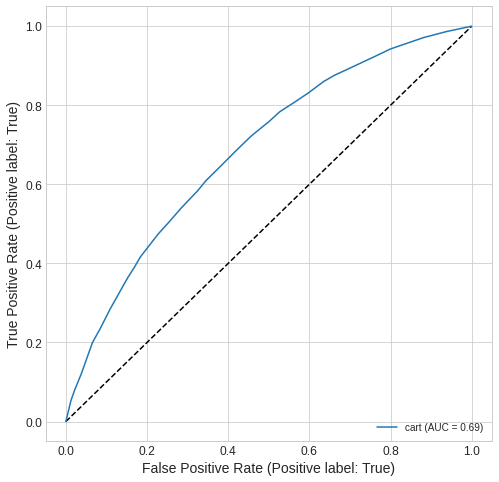

In [23]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

clfs = {
    "cart": cart_search.best_estimator_,
}

fig_roc, ax_roc = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in clfs.items():
    plot_roc_curve(v, df_test, y_test_binary, name=k, ax=ax_roc);

### PR curve
Below you find the precision recall curve for the decision tree. Take some time to compare the two and familiarize yourself with these outputs. What do and what don't they tell you?

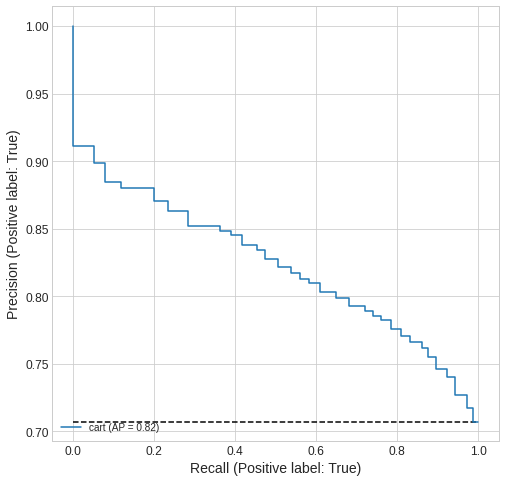

In [24]:
fig_prc, ax_prc = plt.subplots(figsize=S)
plt.plot([0,1], [ y1.iloc[1,1],  y1.iloc[1,1]], 'k--')
for k,v in clfs.items():
    plot_precision_recall_curve(v, df_test, y_test_binary, name=k, ax=ax_prc)

##Random Forest

The next model is an extension of the decision tree just built. Random Forest is a so-called ensemble model, which combines multiple weak learners (in this case multiple decision trees), using an approach called 'bagging'.

In [25]:
%%time
from sklearn.ensemble import RandomForestClassifier


rf = Pipeline(
    steps=[("prep", prep), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
rf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
}
rf_search = GridSearchCV(rf, rf_parameters, cv=5)
_ = rf_search.fit(df_train, y_train_binary)

CPU times: user 1min 31s, sys: 2.71 s, total: 1min 34s
Wall time: 2min 14s


## XGBoost

The GradientBoostingClassifier in sklearn is quite slow, so it is faster to use [XGboost](https://xgboost.readthedocs.io/en/latest/index.html). After installing it separately, you can use the sklearn API to use it in our existing pipeline, and run the model as we are used to.

In [26]:
%%time
import xgboost

xgb = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier(random_state=42))])
_ = xgb.fit(df_train, y_train_binary)

CPU times: user 10.7 s, sys: 108 ms, total: 10.8 s
Wall time: 10.9 s


We proceed by showing the confusion matrix, comparing modeled to true outcomes:

In [27]:
confusion_matrix(y_train_binary, rf_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.07 , 0.223],
       [0.041, 0.666]])

In [28]:
confusion_matrix(y_train_binary, xgb.predict(df_train), normalize='all').round(3)

array([[0.074, 0.218],
       [0.044, 0.664]])

And then compare the ROC and Precision-Recall curves for Random Forest as well as XGBoost:

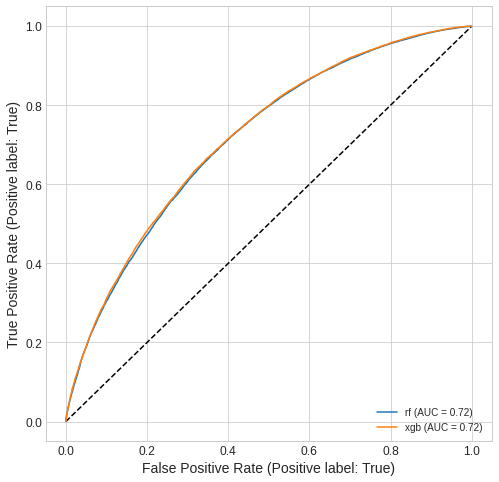

In [29]:
ensembles = {
    "rf": rf_search.best_estimator_,
    "xgb": xgb,
}

fig_roc2, ax_roc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in ensembles.items():
    plot_roc_curve(v, df_train, y_train_binary, name=k, ax=ax_roc2)

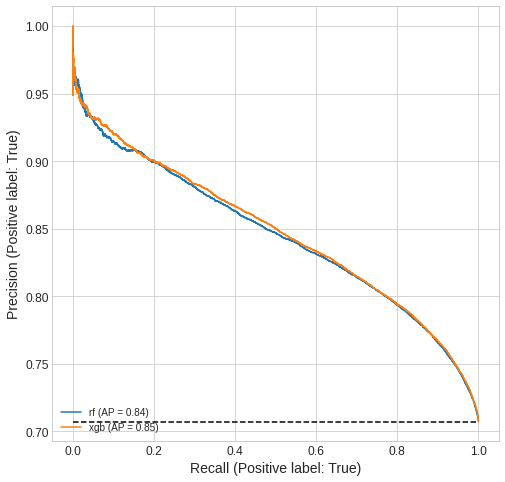

In [30]:
fig_prc2, ax_prc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc2)

Recall that so far we have only assessed performance on the train set. For an honest assessment of performance we should use the test set:

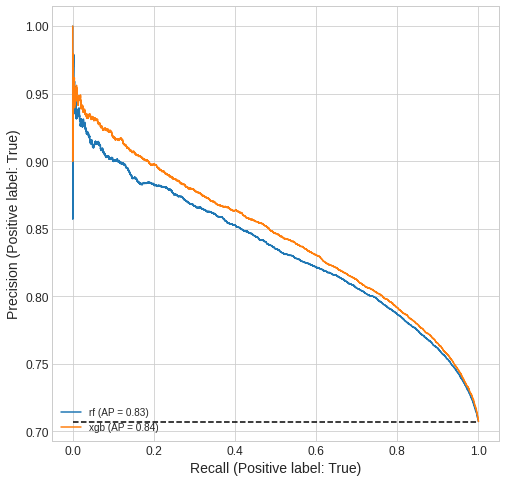

In [31]:
fig_prc2a, ax_prc2a = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_test, y_test_binary, name=k, ax=ax_prc2a)

### Predicting inverse outcomes

We could also turn around the outcomes, which becomes interesting when we plot the precision recall curve.
- why is that the case?
- why is the average precision much lower in this situation?

In [32]:
%%time
# see what performance is for outlier detection
y_train_binary_inverted = np.invert(y_train_binary)

xgb_inv = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier())])
_ = xgb_inv.fit(df_train, y_train_binary_inverted)

CPU times: user 10.4 s, sys: 41.3 ms, total: 10.4 s
Wall time: 10.4 s


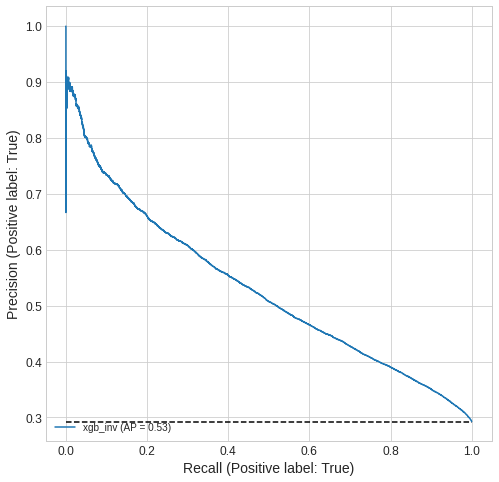

In [33]:
fig_prc4, ax_prc4 = plt.subplots(figsize=S)
plt.plot([0, 1], [1 - y1.iloc[1,1], 1 - y1.iloc[1,1]], 'k--')
plot_precision_recall_curve(xgb_inv, df_train, y_train_binary_inverted, name="xgb_inv", ax=ax_prc4);

### Bonus: Yellowbrick
It really pays off to invest time into enhancing communication about data science results. [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) is a library that can be used for visualizing such results.

0.7158319179940664

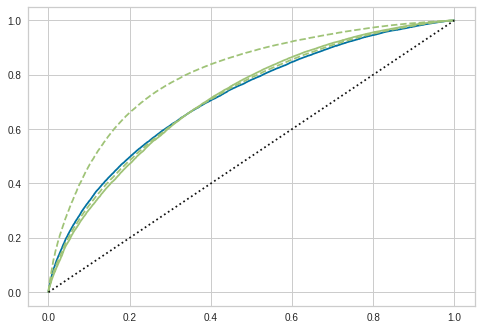

In [34]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

roc = ROCAUC(rf_search.best_estimator_,)
roc.fit(df_train, y_train_binary)
roc.score(df_train, y_train_binary)

0.5286348062698625

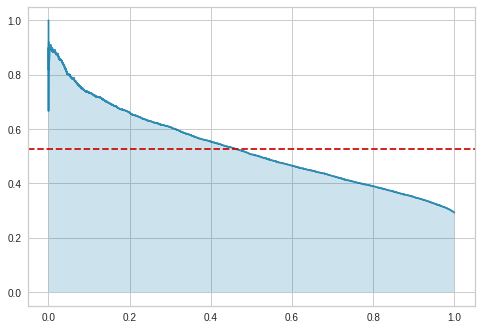

In [35]:
prc = PrecisionRecallCurve(xgb_inv,)
prc.fit(df_train, y_train_binary_inverted)
prc.score(df_train, y_train_binary_inverted)

# Discussion: model assessment and evaluation

We have now seen some of the most commonly used machine learning algorithms. There are many more algorithms available, but they adhere to the same principles and can be applied in the same workflow as we have seen so far. 

We end this notebook with a few general notes on building machine learning algorithms and interpreting results, looking at:
- Uncertainty in model outcomes
- Feature importance


### Uncertainty in model outcomes

Even if you have a good result, i.e. good performance on the test set, it is good to be aware of the fact that machine learning algorithms tend to arrive at solutions in so-called local optima. Depending on the random state at initialization, the results can vary. The degree to which it varies can be small or large, depending on the algorithm and the data. To illustrate how we get somewhat different models with only slightly different outcomes, let's do five runs of XBGBoost (being the best model we have looked at) with different random states.


In [36]:
runs = [{"random_state": n} for n in range(102, 152, 10)]
for run in runs:
    xgb = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier(random_state=run['random_state'], subsample=0.7))])
    run["model"] = xgb.fit(df_train, y_train_binary)

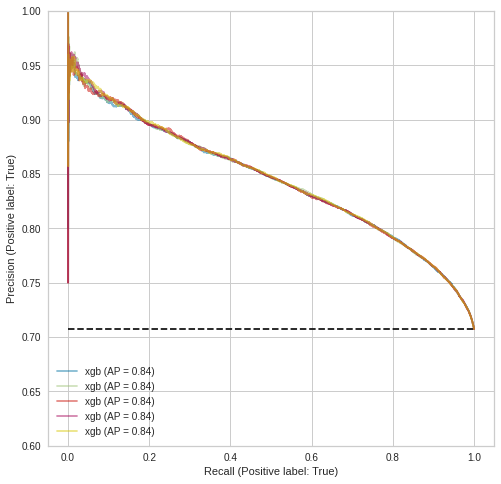

In [37]:
fig_random, ax_random = plt.subplots(figsize=S)
ax_random.set_ylim(0.6, 1.0)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for run in runs:
    plot_precision_recall_curve(run['model'], df_test, y_test_binary, name=k, ax=ax_random, alpha=0.5)

### Feature importance

Although tree-based methods are generally poor in terms of interpretability, we can always compute feature importance. Feature importance shows the relative contribution of the features with respect to their ability to improve the performance of the model. It is useful to get an intuitive feel for which features contain the most information regarding your classification task.

In [38]:
#overwrite the default names (f0, f1, f2, f3, etc.) with the X_column names
xgb['xgb'].get_booster().feature_names = list(X_columns)

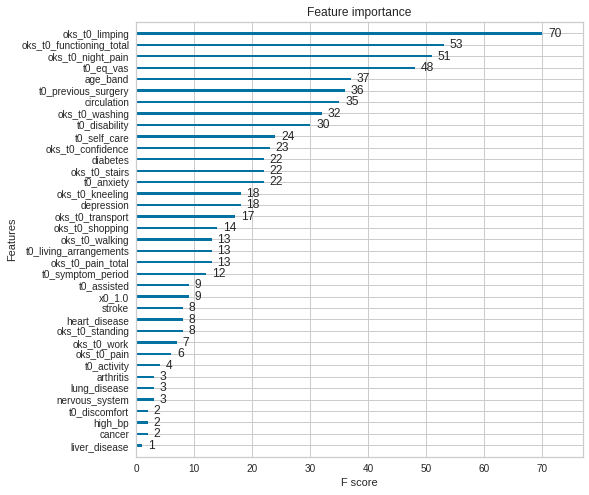

In [39]:
fig_importance, ax_importance = plt.subplots(figsize=S)
xgboost.plot_importance(xgb['xgb'], ax=ax_importance);

# Evaluation of results

Now that we have trained our models, we can select our 'best' model and evaluate whether it is capable of improving clinical practice. We therefore end this notebook with a number of questions aimed to assess to what extent our results can contribute to improving the quality of healthcare:

- Which model would you choose?
- Would you use a prediction model on good outcome or not-good outcomes, or on both?
- At what probability threshold would you use your model? 
- Does your model improve clinical practice?
- Can the model be implemented?
- Given that it can be implemented, where in the process would you implement it?
- What would be ways to further improve the model?


# Conclusion

This brings us to the end of the case study, where we explored, prepared and modeled the data on outcomes for people undergoing knee or hip replacement. Make sure to reach back to these notebooks for reference, when working on a data science project yourself.